<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [IW Tau A](02.01-IWTau-A.ipynb) | [Contents](Index.ipynb) | [V827 Manual IGRINS spectrum cleaning](02.03-V827-manual-cleaning.ipynb) >

# IW Tau A, Enhanced processing

Actually, not sure what's different here!


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [3]:
from astropy.io import fits
import h5py

## Set the date

In [4]:
import pandas as pd

In [5]:
cols = ['OBJECT', 'UTDATE', 'AMSTART','filename_H', 'filename_K']

In [6]:
df = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=cols)

In [7]:
df['out_fn_base'] = df.OBJECT.str.replace(' ', '') + '_'+df.filename_H.str[5:5+8]

In [8]:
df.head()

,filename_H,AMSTART,OBJECT,UTDATE,filename_K,out_fn_base
0,SDCH_20141118_0174.spec_a0v.fits,1.1205,Anon1,2014-11-19,SDCK_20141118_0174.spec_a0v.fits,Anon1_20141118
1,SDCH_20141119_0119.spec_a0v.fits,1.0467,HD283572,2014-11-20,SDCK_20141119_0119.spec_a0v.fits,HD283572_20141119
2,SDCH_20141120_0104.spec_a0v.fits,1.1631,V827Tau,2014-11-21,SDCK_20141120_0104.spec_a0v.fits,V827Tau_20141120
3,SDCH_20141120_0119.spec_a0v.fits,1.0129,Hubble_4,2014-11-21,SDCK_20141120_0119.spec_a0v.fits,Hubble_4_20141120
4,SDCH_20141122_0157.spec_a0v.fits,1.0222,IW Tau A,2014-11-23,SDCK_20141122_0157.spec_a0v.fits,IWTauA_20141122


# Pick the object

In [261]:
obj_index = 4

## H-Band

In [262]:
fn = '../data/IGRINS/MGS_data_request/'+ df.get_value(obj_index, 'filename_H')
hdu_raw = fits.open(fn)
hdr = hdu_raw[0].header

In [263]:
hdu_raw.info()

Filename: ../data/IGRINS/MGS_data_request/SDCH_20141122_0157.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     281   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       280   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       280   (2048, 28)   float64   
  5  SPEC_DIVIDE_CONT    1 ImageHDU       280   (2048, 28)   float64   


### We'll have to make some assumptions

Ideally we would use a noise derived from the pipeline, but we don't have that.  So we assume:  

1. Homoscedastic uncertainty, fixed at $S/N\sim 50$
2. The absolute mean value is non-physical

$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} \times \hat{f}_{std}$$


$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 } \times \hat{f}_{std}$$


**Translation**:

0. `SPEC_DIVIDE_A0V` `............` $f_{\star}$
1. `WAVELENGTH` `.................` $\lambda$ (micron)
2. `TGT_SPEC` `...................` $f_{raw, \star}$
3. `A0V_SPEC` `...................` $f_{raw, std}$
4. `VEGA_SPEC` `..................` $\hat{f}_{std}$
5. `SPEC_DIVIDE_CONT` `...........` *N/A*

Other needed data not included in the `*spec_a0v.fits` file:

- $\sigma_{\star}$ ............ what we want  
- $\sigma_{raw, \star}$ ....... pipeline-produced uncertainty of the star. 
- $\sigma_{raw, std}$ ......... pipeline-produced uncertainty of the A0V standard.


The $\sigma$'s are *unavailable*.
We'll have to "estimate" them:  
Assume homoscedastic*: $\sim0.02 \times$ "continuum"

Let's estimate the uncertainty as:  

$$ \sigma_{raw, \star, m} \approx \hat \sigma_{raw, \star, m}$$

$$\hat \sigma_{raw, \star, m} = f_{raw, \star, m}\mid_{50\%} \times 0.02$$  
where $\mid_{50\%}$ denotes taking the median value, and $m$ indicates that this estimator is computed for each spectral order.  The value of 0.02 is made up, but roughly corresponds to a signal-to-noise ratio of 50 per pixel, which seems reasonable.  

Since our spectral orders are not flux calibrated, we can divide-out the relative flux among orders.  We adopt the per-order median as the normalization, so we have:

$$f_{raw,m}\mid_{50\%} \equiv 1.0$$  

So:

$$\hat \sigma_{raw} = 0.02$$

In [264]:
def get_wl_flux_unc(hdu_raw):
    '''
    Takes in a fits HDU file and returns the wavelength, flux, and uncertainty estimate
    '''
    wl = hdu_raw[1].data
    pipeline_flux_est = hdu_raw[0].data/(np.nanmedian(hdu_raw[0].data, axis=1)[:, np.newaxis])
    flux_raw_star = hdu_raw[2].data/(np.nanmedian(hdu_raw[2].data, axis=1)[:, np.newaxis])
    flux_raw_std = hdu_raw[3].data/(np.nanmedian(hdu_raw[3].data, axis=1)[:, np.newaxis])
    hat_flux_std = hdu_raw[4].data/(np.nanmedian(hdu_raw[4].data, axis=1)[:, np.newaxis])
    
    flux_star = flux_raw_star / flux_raw_std * hat_flux_std
    sig_star = flux_star * np.sqrt( (0.02*flux_raw_star)**2 +
                                (0.02*flux_raw_std)**2 ) * hat_flux_std
    
    renorm_values = np.nanmedian(flux_star, axis=1)[:, np.newaxis]
    norm_flux_star = flux_star/renorm_values
    norm_sig_star = np.abs(sig_star/renorm_values)
    
    return (wl, norm_flux_star, norm_sig_star)

## Clean the data:

- Enforce minimum sigma of 0.02.
- Enforce a maximum S/N of 40.
- Downweight spurious outliers.

In [265]:
def clean_noise(fstar, sig_star):
    '''
    Cleans the sig_star array to account for outliers and S/N limits
    '''
    
    low_sig = sig_star < 0.02
    sig_star[low_sig] = 0.02
    
    s_n = fstar/sig_star
    high_sn = s_n > 40.0
    sig_star[high_sn] = fstar[high_sn]/40.0
    
    neg_flux = fstar < 0.0
    lo_flux = (fstar > 0.0) & (fstar < 0.2)
    high_flux = fstar > 1.5
    sig_star[neg_flux] = np.abs(fstar[neg_flux])+1.0
    sig_star[lo_flux] = fstar[lo_flux]
    sig_star[high_flux] = fstar[high_flux]
    
    return (fstar, sig_star)

In [266]:
wl, fstar, sig_star = get_wl_flux_unc(hdu_raw)

In [267]:
fstar, sig_star = clean_noise(fstar, sig_star)

### Visualize final noise distribution

In [268]:
good_draws = np.random.normal(1.0, 0.05, 25*2048)
bad_draws = np.random.normal(1.0, 5, 3*2048)
comb_draws = np.hstack([good_draws, bad_draws])

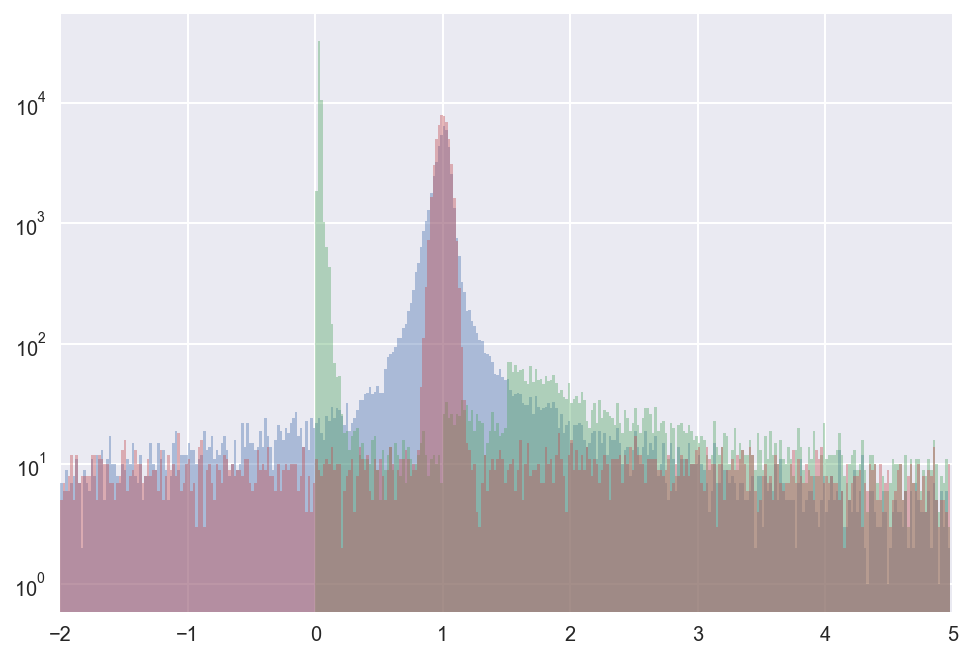

In [269]:
sns.distplot(fstar[fstar==fstar], kde=False, bins=np.arange(-2, 5, 0.02))
sns.distplot(sig_star[sig_star==sig_star], kde=False, bins=np.arange(-2, 5, 0.02))
sns.distplot(comb_draws, kde=False, bins=np.arange(-2, 5, 0.02))
plt.xlim(-2, 5)
plt.yscale('log')

In [270]:
s_n = fstar/sig_star

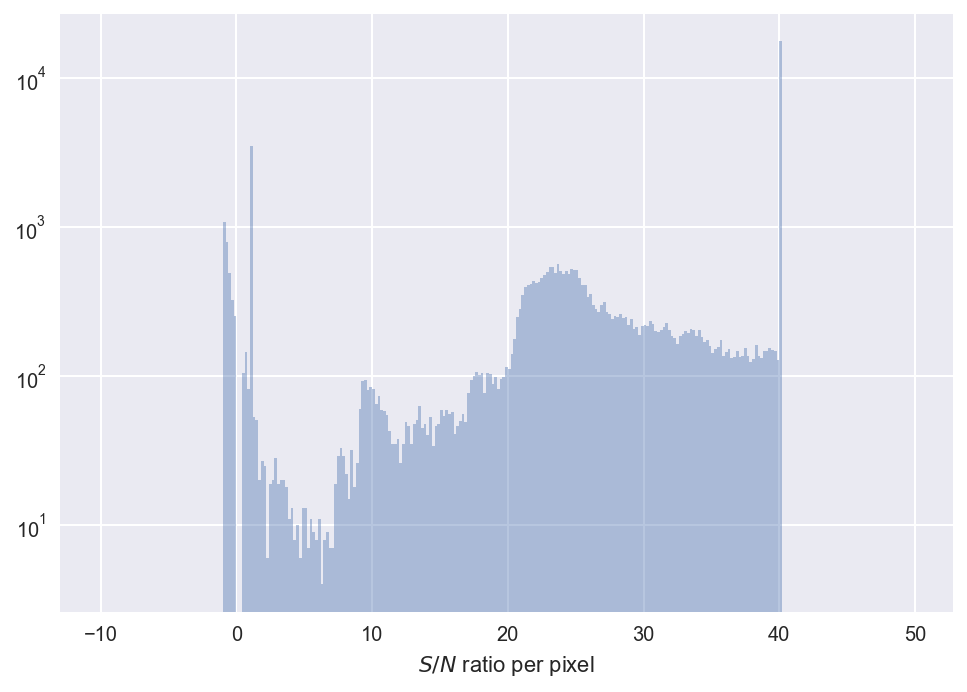

In [271]:
sns.distplot(s_n[s_n==s_n], kde=False, bins=np.arange(-10, 50, 0.2))
#sns.distplot(comb_draws, kde=False, bins=np.arange(-2, 5, 0.02))
plt.xlabel('$S/N$ ratio per pixel')
plt.yscale('log')

## Plot it

We will trim between pixel 450 and 1950.

In [272]:
o=0

In [302]:
fls_out = fstar[o,:]
sig_out = sig_star[o,:]
wls_out = wl[o,:]
sig = sig_out

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k.', ms=4)

plt.fill_between(pix, fls_out-sig, fls_out+sig, color='r')

plt.vlines(450, 0, 2, linestyles='--')
plt.vlines(1950, 0, 2, linestyles='--')
plt.hlines(1.5, 0, 2048, linestyles=':', colors='b')
plt.hlines(0.2, 0, 2048, linestyles=':', colors='b')
plt.ylim(0.0, 2.0)
o+=1

IndexError: index 28 is out of bounds for axis 0 with size 28

In [303]:
lft = 450
rgt = 1950

for o in range(28):
    m = o + 98
    base = df.get_value(obj_index, 'out_fn_base')
    out_name = '../data/IGRINS/reduced/{}_{:03d}.hdf5'.format(base, m)
    fls_out = fstar[o,lft:rgt]
    sig_out = sig_star[o,lft:rgt]
    wls_out = wl[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    gi = (fls_out==fls_out) & (sig_out==sig_out) & (fls_out> 0) & (fls_out < 2)
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out[gi])
    f_new.create_dataset('wls', data=wls_out[gi])
    f_new.create_dataset('sigmas', data=sig_out[gi])
    f_new.create_dataset('masks', data=msk_out[gi])
    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls_out[0], wls_out[-1], out_name))
    f_new.close()

098: 18154  -  18335   ../data/IGRINS/reduced/IWTauA_20141122_098.hdf5
099: 17975  -  18155   ../data/IGRINS/reduced/IWTauA_20141122_099.hdf5
100: 17800  -  17978   ../data/IGRINS/reduced/IWTauA_20141122_100.hdf5
101: 17628  -  17805   ../data/IGRINS/reduced/IWTauA_20141122_101.hdf5
102: 17460  -  17635   ../data/IGRINS/reduced/IWTauA_20141122_102.hdf5
103: 17295  -  17468   ../data/IGRINS/reduced/IWTauA_20141122_103.hdf5
104: 17133  -  17305   ../data/IGRINS/reduced/IWTauA_20141122_104.hdf5
105: 16975  -  17145   ../data/IGRINS/reduced/IWTauA_20141122_105.hdf5
106: 16819  -  16988   ../data/IGRINS/reduced/IWTauA_20141122_106.hdf5
107: 16667  -  16834   ../data/IGRINS/reduced/IWTauA_20141122_107.hdf5
108: 16517  -  16682   ../data/IGRINS/reduced/IWTauA_20141122_108.hdf5
109: 16370  -  16534   ../data/IGRINS/reduced/IWTauA_20141122_109.hdf5
110: 16226  -  16388   ../data/IGRINS/reduced/IWTauA_20141122_110.hdf5
111: 16084  -  16245   ../data/IGRINS/reduced/IWTauA_20141122_111.hdf5
112: 1

## K-band

In [304]:
fn = '../data/IGRINS/MGS_data_request/'+ df.get_value(obj_index, 'filename_K')
hdu_raw = fits.open(fn)
hdr = hdu_raw[0].header

In [305]:
wl, fstar, sig_star = get_wl_flux_unc(hdu_raw)
fstar, sig_star = clean_noise(fstar, sig_star)

In [306]:
good_draws = np.random.normal(1.0, 0.05, 23*2048)
bad_draws = np.random.normal(1.0, 5, 3*2048)
comb_draws = np.hstack([good_draws, bad_draws])

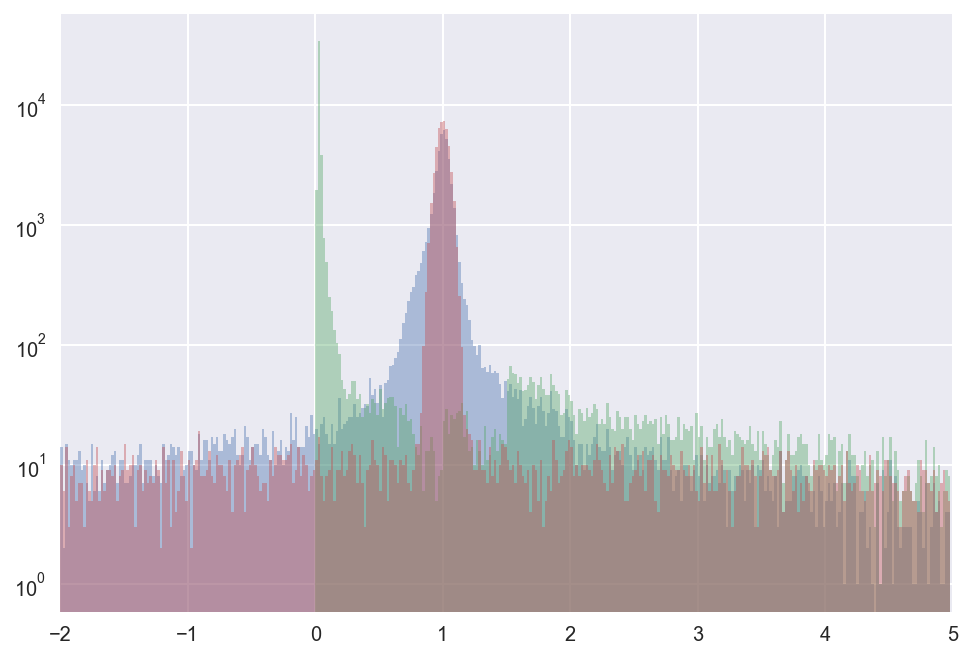

In [307]:
sns.distplot(fstar[fstar==fstar], kde=False, bins=np.arange(-2, 5, 0.02))
sns.distplot(sig_star[sig_star==sig_star], kde=False, bins=np.arange(-2, 5, 0.02))
sns.distplot(comb_draws, kde=False, bins=np.arange(-2, 5, 0.02))
plt.xlim(-2, 5)
plt.yscale('log')

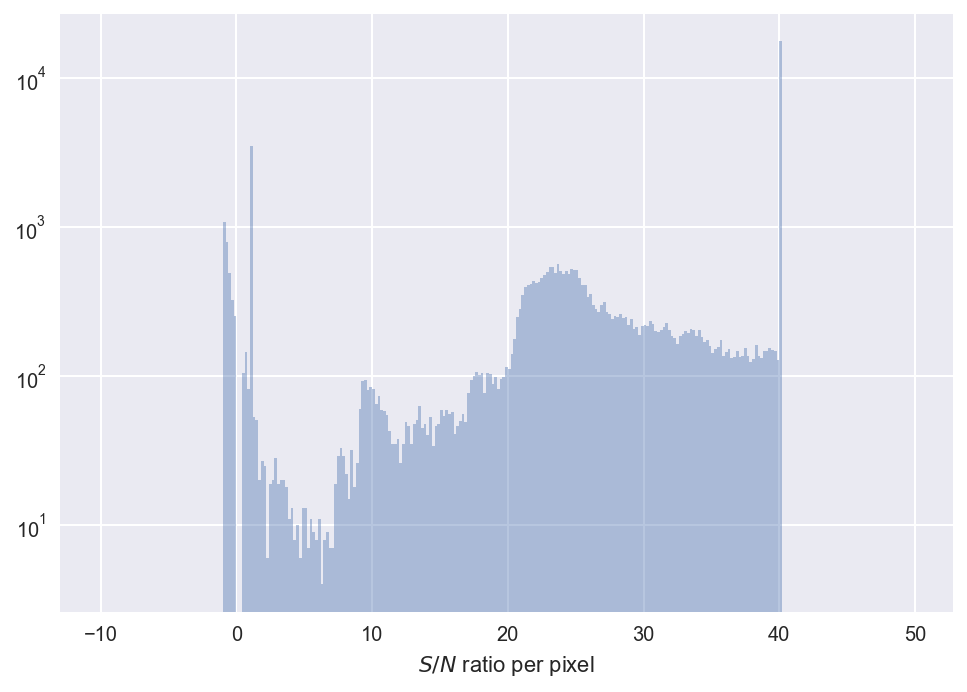

In [308]:
sns.distplot(s_n[s_n==s_n], kde=False, bins=np.arange(-10, 50, 0.2))
#sns.distplot(comb_draws, kde=False, bins=np.arange(-2, 5, 0.02))
plt.xlabel('$S/N$ ratio per pixel')
plt.yscale('log')

In [309]:
o=0

In [336]:
fls_out = fstar[o,:]
sig_out = sig_star[o,:]
wls_out = wl[o,:]
sig = sig_out

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k.', ms=4)

plt.fill_between(pix, fls_out-sig, fls_out+sig, color='r')

plt.vlines(450, 0, 2, linestyles='--')
plt.vlines(1950, 0, 2, linestyles='--')
plt.hlines(1.5, 0, 2048, linestyles=':', colors='b')
plt.hlines(0.2, 0, 2048, linestyles=':', colors='b')
plt.ylim(0.0, 2.0)
o+=1

IndexError: index 26 is out of bounds for axis 0 with size 26

In [337]:
lft = 450
rgt = 1950

for o in range(26):
    m = o + 71
    base = df.get_value(obj_index, 'out_fn_base')
    out_name = '../data/IGRINS/reduced/{}_{:03d}.hdf5'.format(base, m)
    fls_out = fstar[o,lft:rgt]
    sig_out = sig_star[o,lft:rgt]
    wls_out = wl[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    gi = (fls_out==fls_out) & (sig_out==sig_out) & (fls_out > 0) & (fls_out < 2)
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out[gi])
    f_new.create_dataset('wls', data=wls_out[gi])
    f_new.create_dataset('sigmas', data=sig_out[gi])
    f_new.create_dataset('masks', data=msk_out[gi])
    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls_out[0], wls_out[-1], out_name))
    f_new.close()

071: 24928  -  25173   ../data/IGRINS/reduced/IWTauA_20141122_071.hdf5
072: 24586  -  24828   ../data/IGRINS/reduced/IWTauA_20141122_072.hdf5
073: 24254  -  24492   ../data/IGRINS/reduced/IWTauA_20141122_073.hdf5
074: 23930  -  24166   ../data/IGRINS/reduced/IWTauA_20141122_074.hdf5
075: 23616  -  23849   ../data/IGRINS/reduced/IWTauA_20141122_075.hdf5
076: 23309  -  23540   ../data/IGRINS/reduced/IWTauA_20141122_076.hdf5
077: 23011  -  23239   ../data/IGRINS/reduced/IWTauA_20141122_077.hdf5
078: 22720  -  22945   ../data/IGRINS/reduced/IWTauA_20141122_078.hdf5
079: 22437  -  22660   ../data/IGRINS/reduced/IWTauA_20141122_079.hdf5
080: 22161  -  22381   ../data/IGRINS/reduced/IWTauA_20141122_080.hdf5
081: 21892  -  22109   ../data/IGRINS/reduced/IWTauA_20141122_081.hdf5
082: 21630  -  21844   ../data/IGRINS/reduced/IWTauA_20141122_082.hdf5
083: 21374  -  21586   ../data/IGRINS/reduced/IWTauA_20141122_083.hdf5
084: 21124  -  21334   ../data/IGRINS/reduced/IWTauA_20141122_084.hdf5
085: 2

### The end!

<!--NAVIGATION-->
< [IW Tau A](02.01-IWTau-A.ipynb) | [Contents](Index.ipynb) | [V827 Manual IGRINS spectrum cleaning](02.03-V827-manual-cleaning.ipynb) >